# **Cell and Other Classification**



In this notebook we are going to train a CNN-based model for a multi-class classification task, Cell and Other Classification classification. The dataset we are going to use is a small imbalanced one.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.

# Imports

First of all we need to import required libraries.

In [1]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Preparing Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Set the directory containing the images
data_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/classifier_data/'

classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] not in ['JPEG' , ".png"]:
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

In [4]:
classes

['cell', 'other']

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [5]:
# Set up directories and data splits
root_dir = data_dir
# classes = os.listdir(data_dir)

############## To Do ##############
train_split = 0.8
val_split = 0.1
test_split = 0.1
###################################

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

############## To Do ##############
# Create train, validation and test splits
# Also print the number of samples in each class
train_images = []
val_images = []
test_images = []
for cls_name, images in data_dict.items():
  num_images = len(images)
  num_train = int(train_split * num_images)
  num_val = int(val_split * num_images)
  num_test = num_images - num_train - num_val

  train_images += [img_path for img_path in images[:num_train]]
  val_images += [img_path for img_path in images[num_train:num_train+num_val]]
  test_images += [img_path for img_path in images[num_train+num_val:]]

  print(f"{cls_name}: {num_images}: {num_train} for training, {num_val} for validation, and {num_test} for testing.")
  # print(cls_name + ": " + str(len(images)))
###################################

cell: 120: 96 for training, 12 for validation, and 12 for testing.
other: 1000: 800 for training, 100 for validation, and 100 for testing.


**Question:** How many classes are there in your dataset?

**Question:** Did you notice the imbalance between classes?

We put samples of each group in a seperate folder.

In [9]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[-2]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[-2:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[-2]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[-2:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[-2]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[-2:]))

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘val’: File exists
mkdir: cannot create directory ‘test’: File exists


## 1.3) Calculate Weights of Calsses: 5

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 120 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [17]:
############## To Do ##############
wgts = []

root_dir = 'train'
classes = os.listdir(root_dir)
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

classes.remove(".ipynb_checkpoints")
for c in classes:
    print(c)
    class_size = len(data_dict[str(c)])
    class_weight = (max([len(data_dict[x]) for x in data_dict])/class_size)
    # class_weight = (4207/class_size)
    wgts.append(class_weight)
    print('Size of Class: ' + str(class_size))
    print('Weight of Class: ' + str(class_weight))
    print()

wgts = torch.Tensor(wgts)
###################################

other
Size of Class: 800
Weight of Class: 1.0

cell
Size of Class: 96
Weight of Class: 8.333333333333334



## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [18]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [57]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]
        return image, label


############## To Do ##############

# Define the transformations to be applied on the train and validation sets
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Create datasets using defined CustomDataset class
train_dataset = CustomDataset(train_images, classes=classes, transform=train_transform)
val_dataset = CustomDataset(val_images, classes=classes, transform=val_transform)
test_dataset = CustomDataset(test_images, classes=classes, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
###################################

In [58]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = len(classes) # Number of classes

## 1.5) Data Visualization

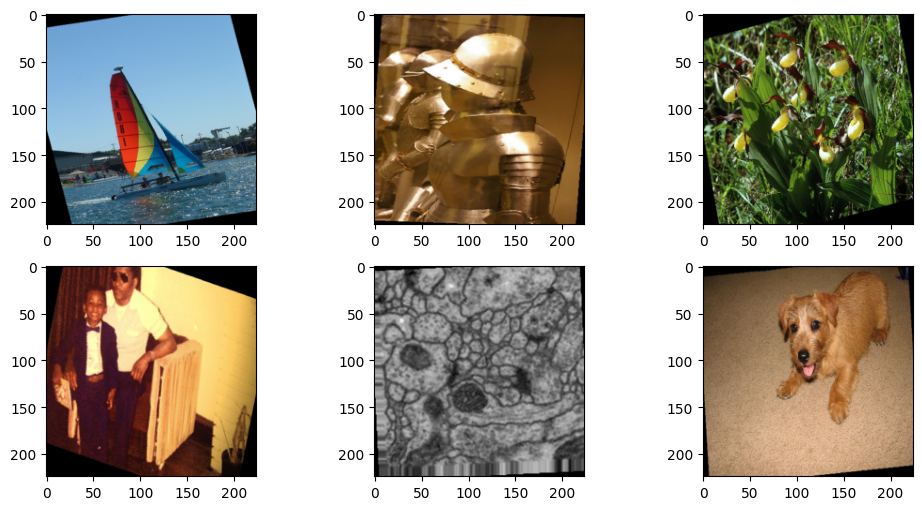

In [59]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [61]:
############## To Do ##############
resnet_model = models.resnet50(pretrained=True)
###################################

# Print the structure of the loaded model
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why?

**fc layer is for classification task**

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [62]:
############## To Do ##############
# Freeze all parameters in the convolutional layers
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the fully connected layer with a new one with num_cls
num_features= resnet_model.fc.in_features  # in hear is 2048
resnet_model.fc = torch.nn.Linear(num_features, num_cls) # in Resnet, it is 1000, but hear it is 2
###################################

# Print the structure of the modified model and notice the difference
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [63]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [64]:
############## To Do ##############
vgg_model = models.vgg16(pretrained=True)
###################################

# Print the structure of the loaded model
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why?

**This model has a classifier part, which is sequential itself, we are going to just change its final layer's output size**

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [65]:
############## To Do ##############
# # Freeze all layers in the model
for param in vgg_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to have 37 output features
num_features = vgg_model.classifier[-1].in_features
vgg_model.classifier[-1] = nn.Linear(num_features, num_cls)
###################################

# Print the structure of the modified model and notice the difference
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [66]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [67]:
wgts = wgts.to(device)

############## To Do ##############
criterion = nn.CrossEntropyLoss(weight=wgts)
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [68]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero the parameter gradients

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs, predictions, and losses
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # Summation of losses
                running_corrects += torch.sum(preds==labels.data) # Summation of true classifications

            epoch_loss =  running_loss / len(dataloaders[phase].dataset) # Average of losses. Use running_loss
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # Accuracy. Use running_corrects

            if phase == 'val' and not(scheduler is None):
                scheduler.step(epoch_loss) # Set scheduler

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist
###################################

# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [54]:
############## To Do ##############
# Freeze all parameters in the convolutional layers
# for param in resnet_model.parameters():
#     param.requires_grad = False
###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [69]:
############## To Do ##############
resnet_optimizer = optim.Adam(list(resnet_model.fc.parameters()), lr=0.001)
###################################
lr_scheduler = None

In [70]:
############## To Do ##############
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None, num_epochs=10)
###################################

Epoch 0/9
----------
train Loss: 0.2662 Acc: 0.9163
val Loss: 0.0146 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.0330 Acc: 0.9967
val Loss: 0.0039 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0287 Acc: 0.9967
val Loss: 0.0052 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0089 Acc: 1.0000
val Loss: 0.0013 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0167 Acc: 0.9978
val Loss: 0.0008 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0194 Acc: 0.9978
val Loss: 0.0006 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0157 Acc: 0.9989
val Loss: 0.0043 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0133 Acc: 0.9978
val Loss: 0.0003 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Training complete in 2m 12s
Best val Acc: 1.000000


### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [71]:
############## To Do ##############
# Freeze all layers in the model
# for param in vgg_model.parameters():
#     param.requires_grad = False
###################################

### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [72]:
############## To Do ##############
vgg_optimizer = optim.Adam(list(vgg_model.classifier.parameters())[-2:], lr=0.001)
###################################

lr_scheduler = None

In [73]:
############## To Do ##############
vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=None, num_epochs=10)
###################################

Epoch 0/9
----------
train Loss: 0.0974 Acc: 0.9844
val Loss: 0.0046 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.0077 Acc: 0.9978
val Loss: 0.0021 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 0.0012 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0049 Acc: 0.9989
val Loss: 0.0009 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0039 Acc: 0.9989
val Loss: 0.0008 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.0004 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Training complete in 2m 15s
Best val Acc: 1.000000


# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [74]:
############## To Do ##############
for param in resnet_model.parameters():
    param.requires_grad_()
###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [75]:
############## To Do ##############
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.0001)

lr_scheduler = None

resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None, num_epochs=30)
###################################

Epoch 0/29
----------
train Loss: 0.0453 Acc: 0.9978
val Loss: 0.0166 Acc: 1.0000

Epoch 1/29
----------
train Loss: 0.0394 Acc: 0.9967
val Loss: 0.0121 Acc: 1.0000

Epoch 2/29
----------
train Loss: 0.0378 Acc: 0.9955
val Loss: 0.0109 Acc: 1.0000

Epoch 3/29
----------
train Loss: 0.0406 Acc: 0.9955
val Loss: 0.0100 Acc: 1.0000

Epoch 4/29
----------
train Loss: 0.0406 Acc: 0.9967
val Loss: 0.0104 Acc: 1.0000

Epoch 5/29
----------
train Loss: 0.0424 Acc: 0.9967
val Loss: 0.0111 Acc: 1.0000

Epoch 6/29
----------
train Loss: 0.0353 Acc: 0.9967
val Loss: 0.0102 Acc: 1.0000

Epoch 7/29
----------
train Loss: 0.0341 Acc: 1.0000
val Loss: 0.0080 Acc: 1.0000

Epoch 8/29
----------
train Loss: 0.0353 Acc: 0.9967
val Loss: 0.0073 Acc: 1.0000

Epoch 9/29
----------
train Loss: 0.0280 Acc: 1.0000
val Loss: 0.0086 Acc: 1.0000

Epoch 10/29
----------
train Loss: 0.0465 Acc: 0.9911
val Loss: 0.0072 Acc: 1.0000

Epoch 11/29
----------
train Loss: 0.0323 Acc: 0.9978
val Loss: 0.0076 Acc: 1.0000

Ep

## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [76]:
############## To Do ##############
for param in vgg_model.parameters():
    param.requires_grad_()
###################################

### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [77]:
############## To Do ##############
vgg_optimizer = optim.SGD(vgg_model.parameters(), lr=0.001)

lr_schedular = None

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=None, num_epochs=30)
###################################

Epoch 0/29
----------
train Loss: 0.0079 Acc: 0.9978
val Loss: 0.0028 Acc: 1.0000

Epoch 1/29
----------
train Loss: 0.0049 Acc: 0.9989
val Loss: 0.0014 Acc: 1.0000

Epoch 2/29
----------
train Loss: 0.0024 Acc: 0.9989
val Loss: 0.0011 Acc: 1.0000

Epoch 3/29
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.0007 Acc: 1.0000

Epoch 4/29
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.0008 Acc: 1.0000

Epoch 5/29
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.0004 Acc: 1.0000

Epoch 6/29
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 7/29
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 8/29
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 9/29
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 10/29
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Epoch 11/29
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000

Ep

## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

In [78]:
res_train_acc_fe = [resnet_acc_fe['train'][i].item() for i in range(len(resnet_acc_fe['train']))]
res_train_acc_ft = [resnet_acc_ft['train'][i].item() for i in range(len(resnet_acc_ft['train']))]
res_val_acc_fe = [resnet_acc_fe['val'][i].item() for i in range(len(resnet_acc_fe['val']))]
res_val_acc_ft = [resnet_acc_ft['val'][i].item() for i in range(len(resnet_acc_ft['val']))]
res_train_acc = res_train_acc_fe + res_train_acc_ft
res_val_acc = res_val_acc_fe + res_val_acc_ft

res_train_loss_fe = [resnet_loss_fe['train'][i] for i in range(len(resnet_loss_fe['train']))]
res_train_loss_ft = [resnet_loss_ft['train'][i] for i in range(len(resnet_loss_ft['train']))]
res_val_loss_fe = [resnet_loss_fe['val'][i] for i in range(len(resnet_loss_fe['val']))]
res_val_loss_ft = [resnet_loss_ft['val'][i] for i in range(len(resnet_loss_ft['val']))]
res_train_loss = res_train_loss_fe + res_train_loss_ft
res_val_loss = res_val_loss_fe + res_val_loss_ft

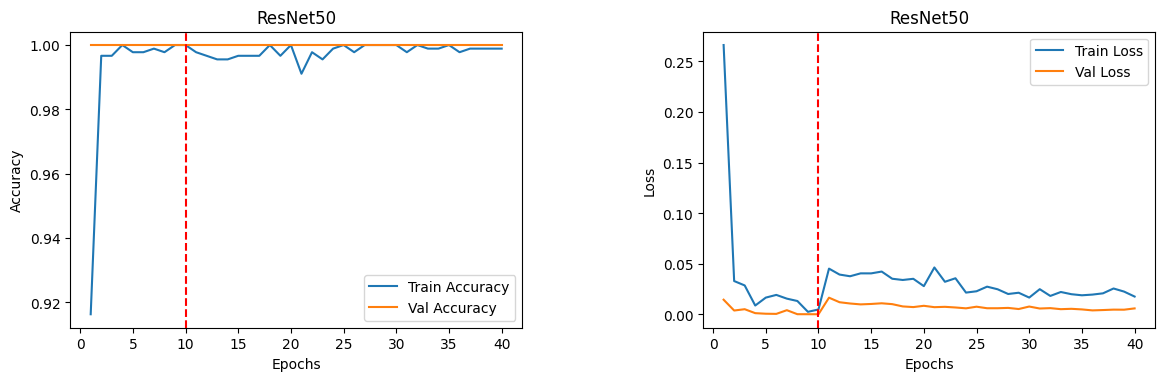

In [79]:
############## To Do ##############

# Plot accuracy and loss for feature extraction

epochs = 40
# Set figure size
plt.figure(figsize=(14, 10))

# Plot 1: ResNet50 Accuracy
plt.subplot(2, 2, 1)
plt.plot(np.arange(1, epochs+1), res_train_acc, label='Train Accuracy')
plt.plot(np.arange(1, epochs+1), res_val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Plot 2: ResNet50 Loss
plt.subplot(2, 2, 2)
plt.plot(np.arange(1, epochs+1), res_train_loss, label='Train Loss')
plt.plot(np.arange(1, epochs+1), res_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()
###################################

In [80]:
vgg_train_acc_fe = [vgg_acc_fe['train'][i].item() for i in range(len(vgg_acc_fe['train']))]
vgg_train_acc_ft = [vgg_acc_ft['train'][i].item() for i in range(len(vgg_acc_ft['train']))]
vgg_val_acc_fe = [vgg_acc_fe['val'][i].item() for i in range(len(vgg_acc_fe['val']))]
vgg_val_acc_ft = [vgg_acc_ft['val'][i].item() for i in range(len(vgg_acc_ft['val']))]
vgg_train_acc = vgg_train_acc_fe + vgg_train_acc_ft
vgg_val_acc = vgg_val_acc_fe + vgg_val_acc_ft


vgg_train_loss_fe = [vgg_loss_fe['train'][i] for i in range(len(vgg_loss_fe['train']))]
vgg_train_loss_ft = [vgg_loss_ft['train'][i] for i in range(len(vgg_loss_ft['train']))]
vgg_val_loss_fe = [vgg_loss_fe['val'][i] for i in range(len(vgg_loss_fe['val']))]
vgg_val_loss_ft = [vgg_loss_ft['val'][i] for i in range(len(vgg_loss_ft['val']))]
vgg_train_loss = vgg_train_loss_fe + vgg_train_loss_ft
vgg_val_loss = vgg_val_loss_fe + vgg_val_loss_ft

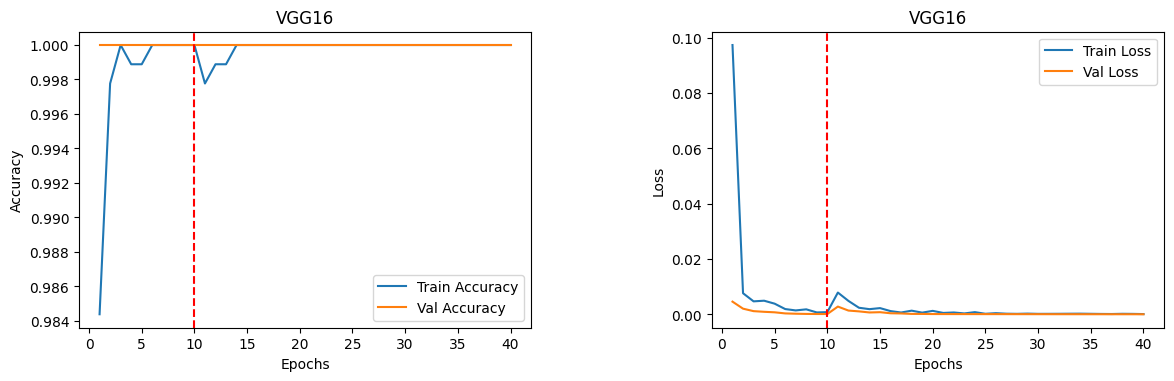

In [81]:
# Plot accuracy and loss for feature extraction

epochs = 40
# Set figure size
plt.figure(figsize=(14, 10))

# Plot 3: VGG16 Accuracy
plt.subplot(2, 2, 1)
plt.plot(np.arange(1, epochs+1), vgg_train_acc, label='Train Accuracy')
plt.plot(np.arange(1, epochs+1), vgg_val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Plot 4: VGG16 Loss
plt.subplot(2, 2, 2)
plt.plot(np.arange(1, epochs+1), vgg_train_loss, label='Train Loss')
plt.plot(np.arange(1, epochs+1), vgg_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()


## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

In [82]:
############## To Do ##############
def plot_confusion_matrix(model,dataloader,classes):

  model.eval() # Set the model to evaluation mode

  predictions = []
  labels = []
  with torch.no_grad():
      for images, label in dataloader:
          images = images.to(device)
          labels.extend(label)
          label = label.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          predictions.extend(predicted.cpu().numpy())

  labels = [int(tensor.numpy()) for tensor in labels]

  num_correct = 0
  for i in range(len(labels)):
      if predictions[i] == labels[i]:
          num_correct += 1

  accuracy = (num_correct / len(labels)) * 100

  # Compute confusion matrix
  cm = confusion_matrix(labels, predictions)

  # Set figure size
  fig, ax = plt.subplots(figsize=(30, 20))

  # Plot confusion matrix with color map
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
  ax.figure.colorbar(im, ax=ax)

  # Add title and axis labels
  ax.set(title='ResNet50',
        xlabel='Predicted label',
        ylabel='True label')

  # Add tick marks and labels for axes
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks)
  ax.set_xticklabels(classes)
  ax.set_yticks(tick_marks)
  ax.set_yticklabels(classes)

  # Add values to each cell
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], 'd'),
                  ha="center", va="center",
                  color="black" if cm[i, j] > thresh else "yellow")

  # Display plot
  plt.show()

  return accuracy
###################################

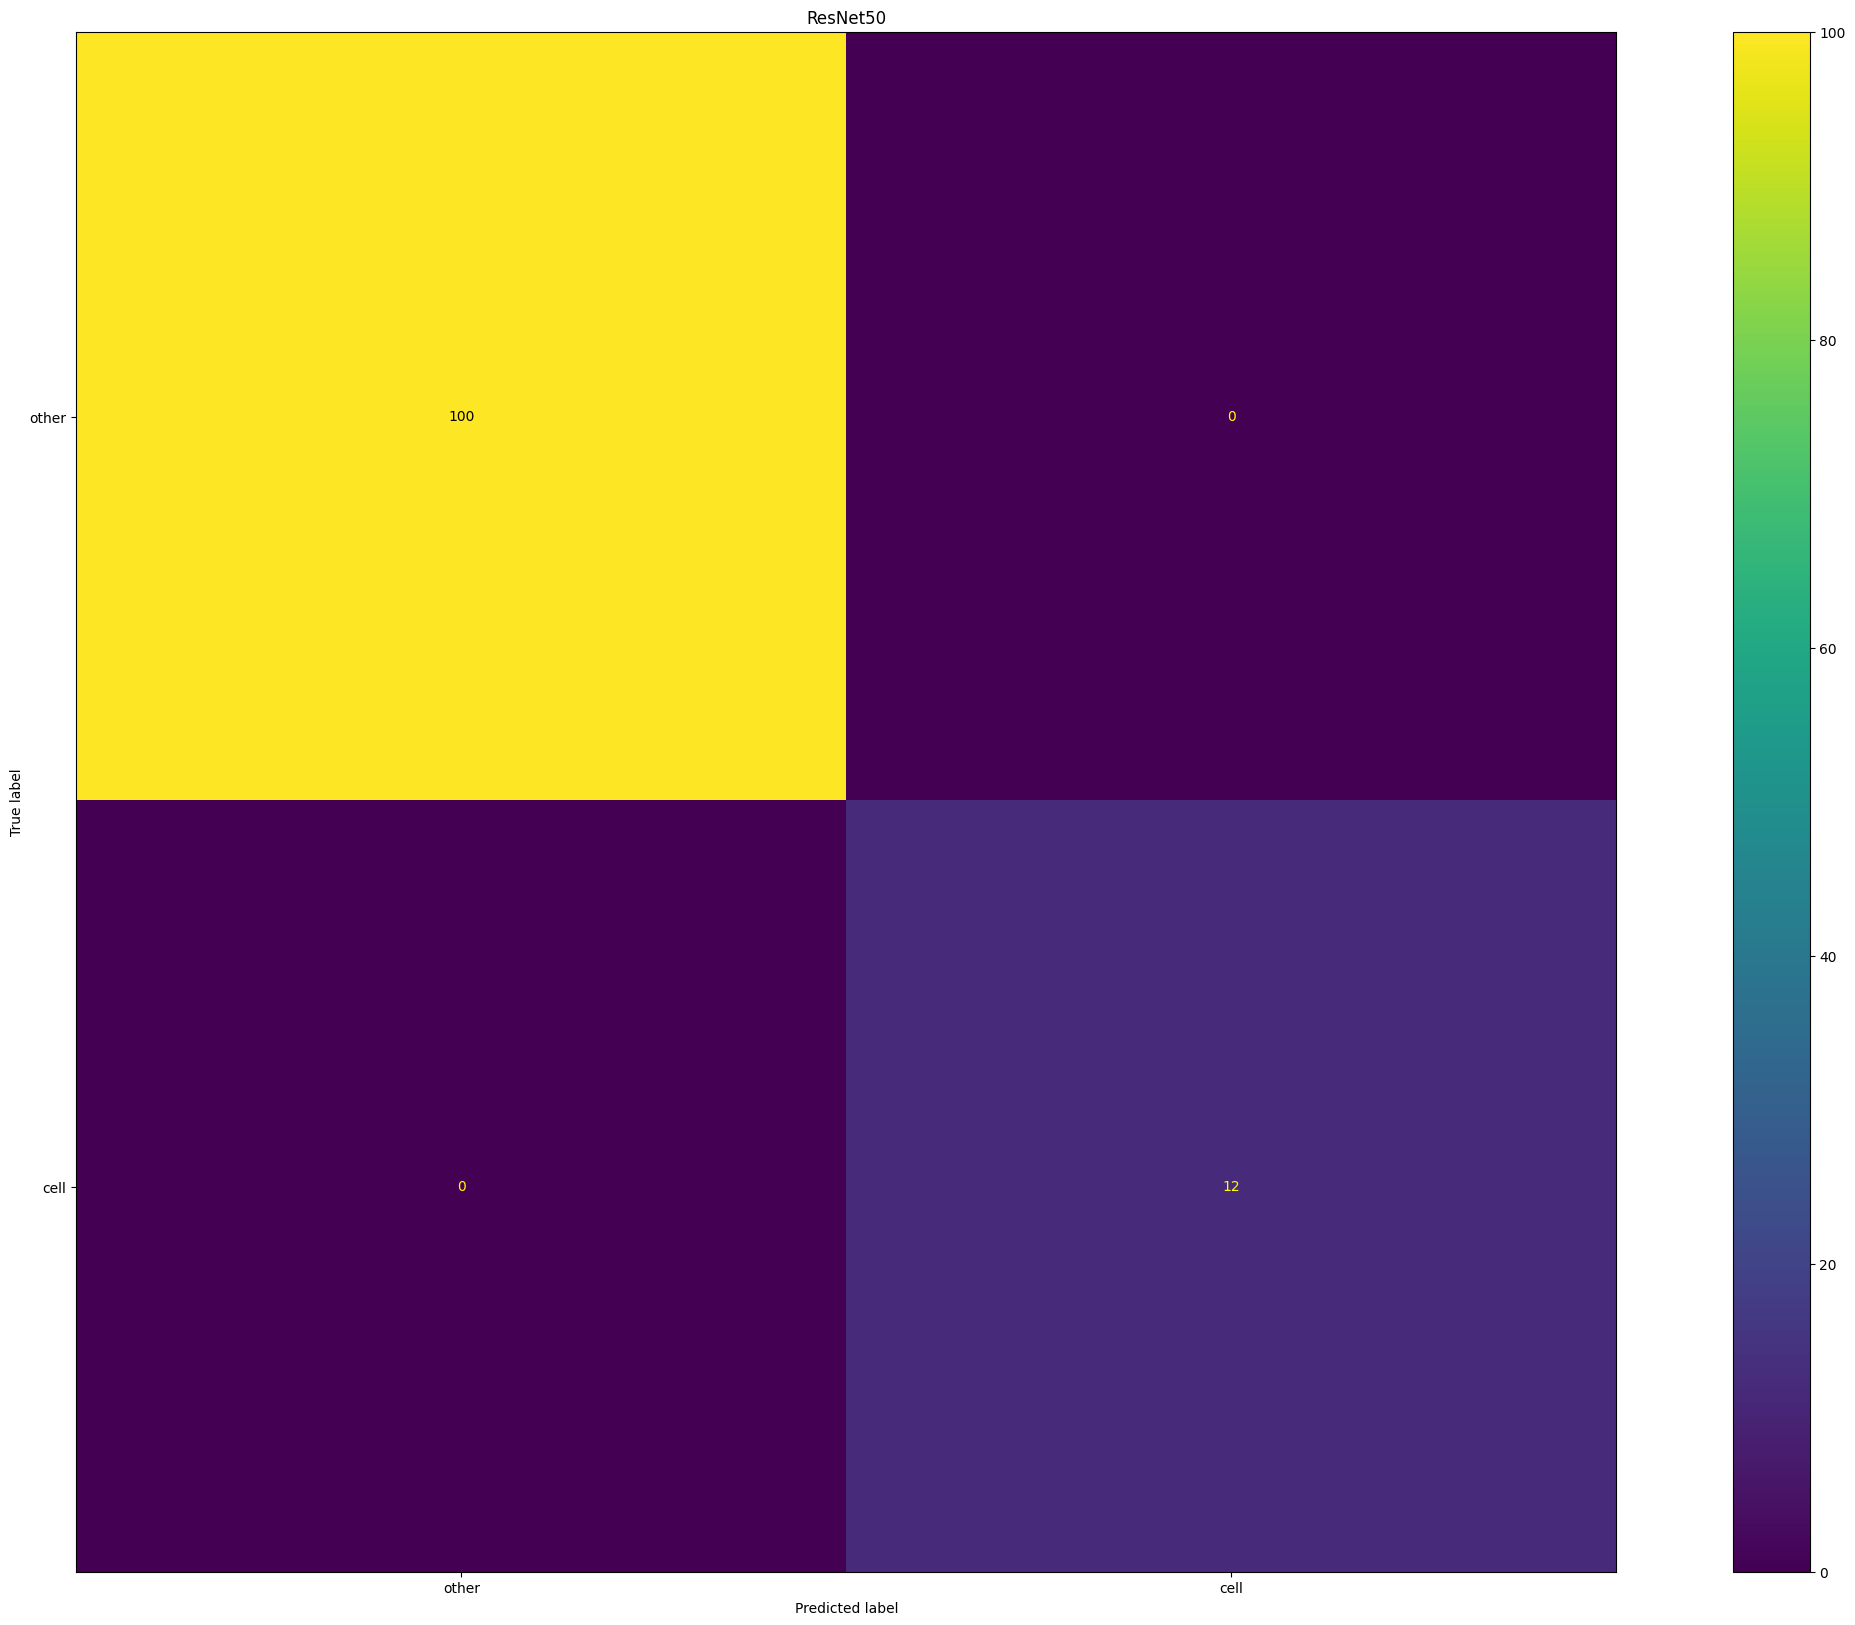

In [83]:
res_val_acc = plot_confusion_matrix(resnet_ft,val_loader,classes)

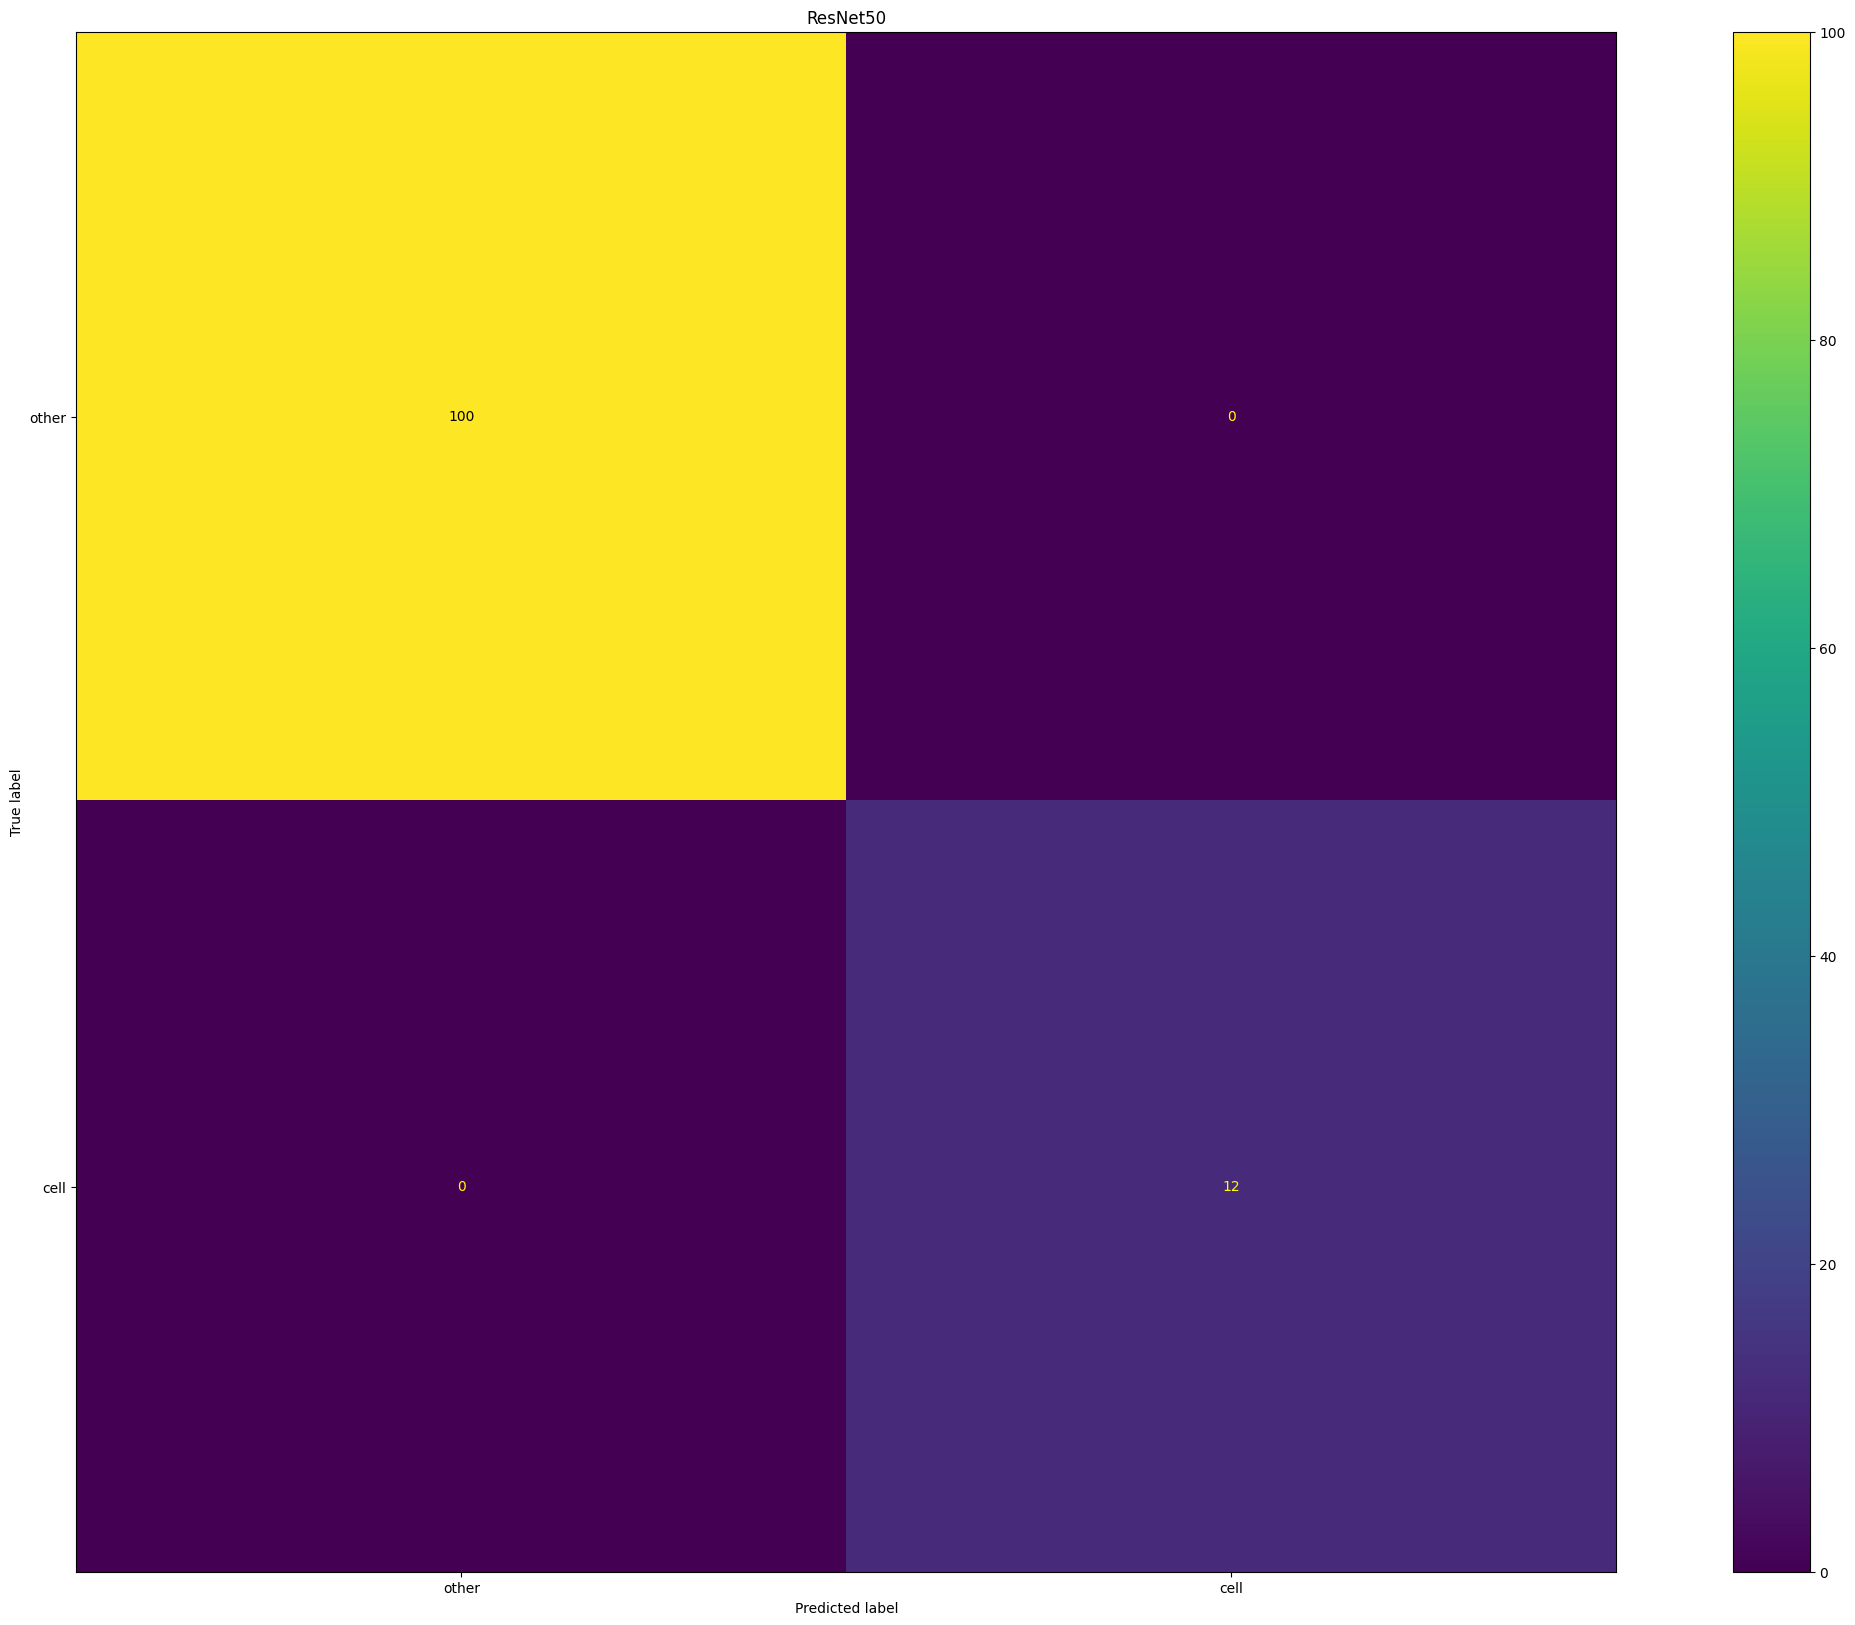

In [84]:
vgg_val_acc = plot_confusion_matrix(vgg_ft,val_loader,classes)

# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

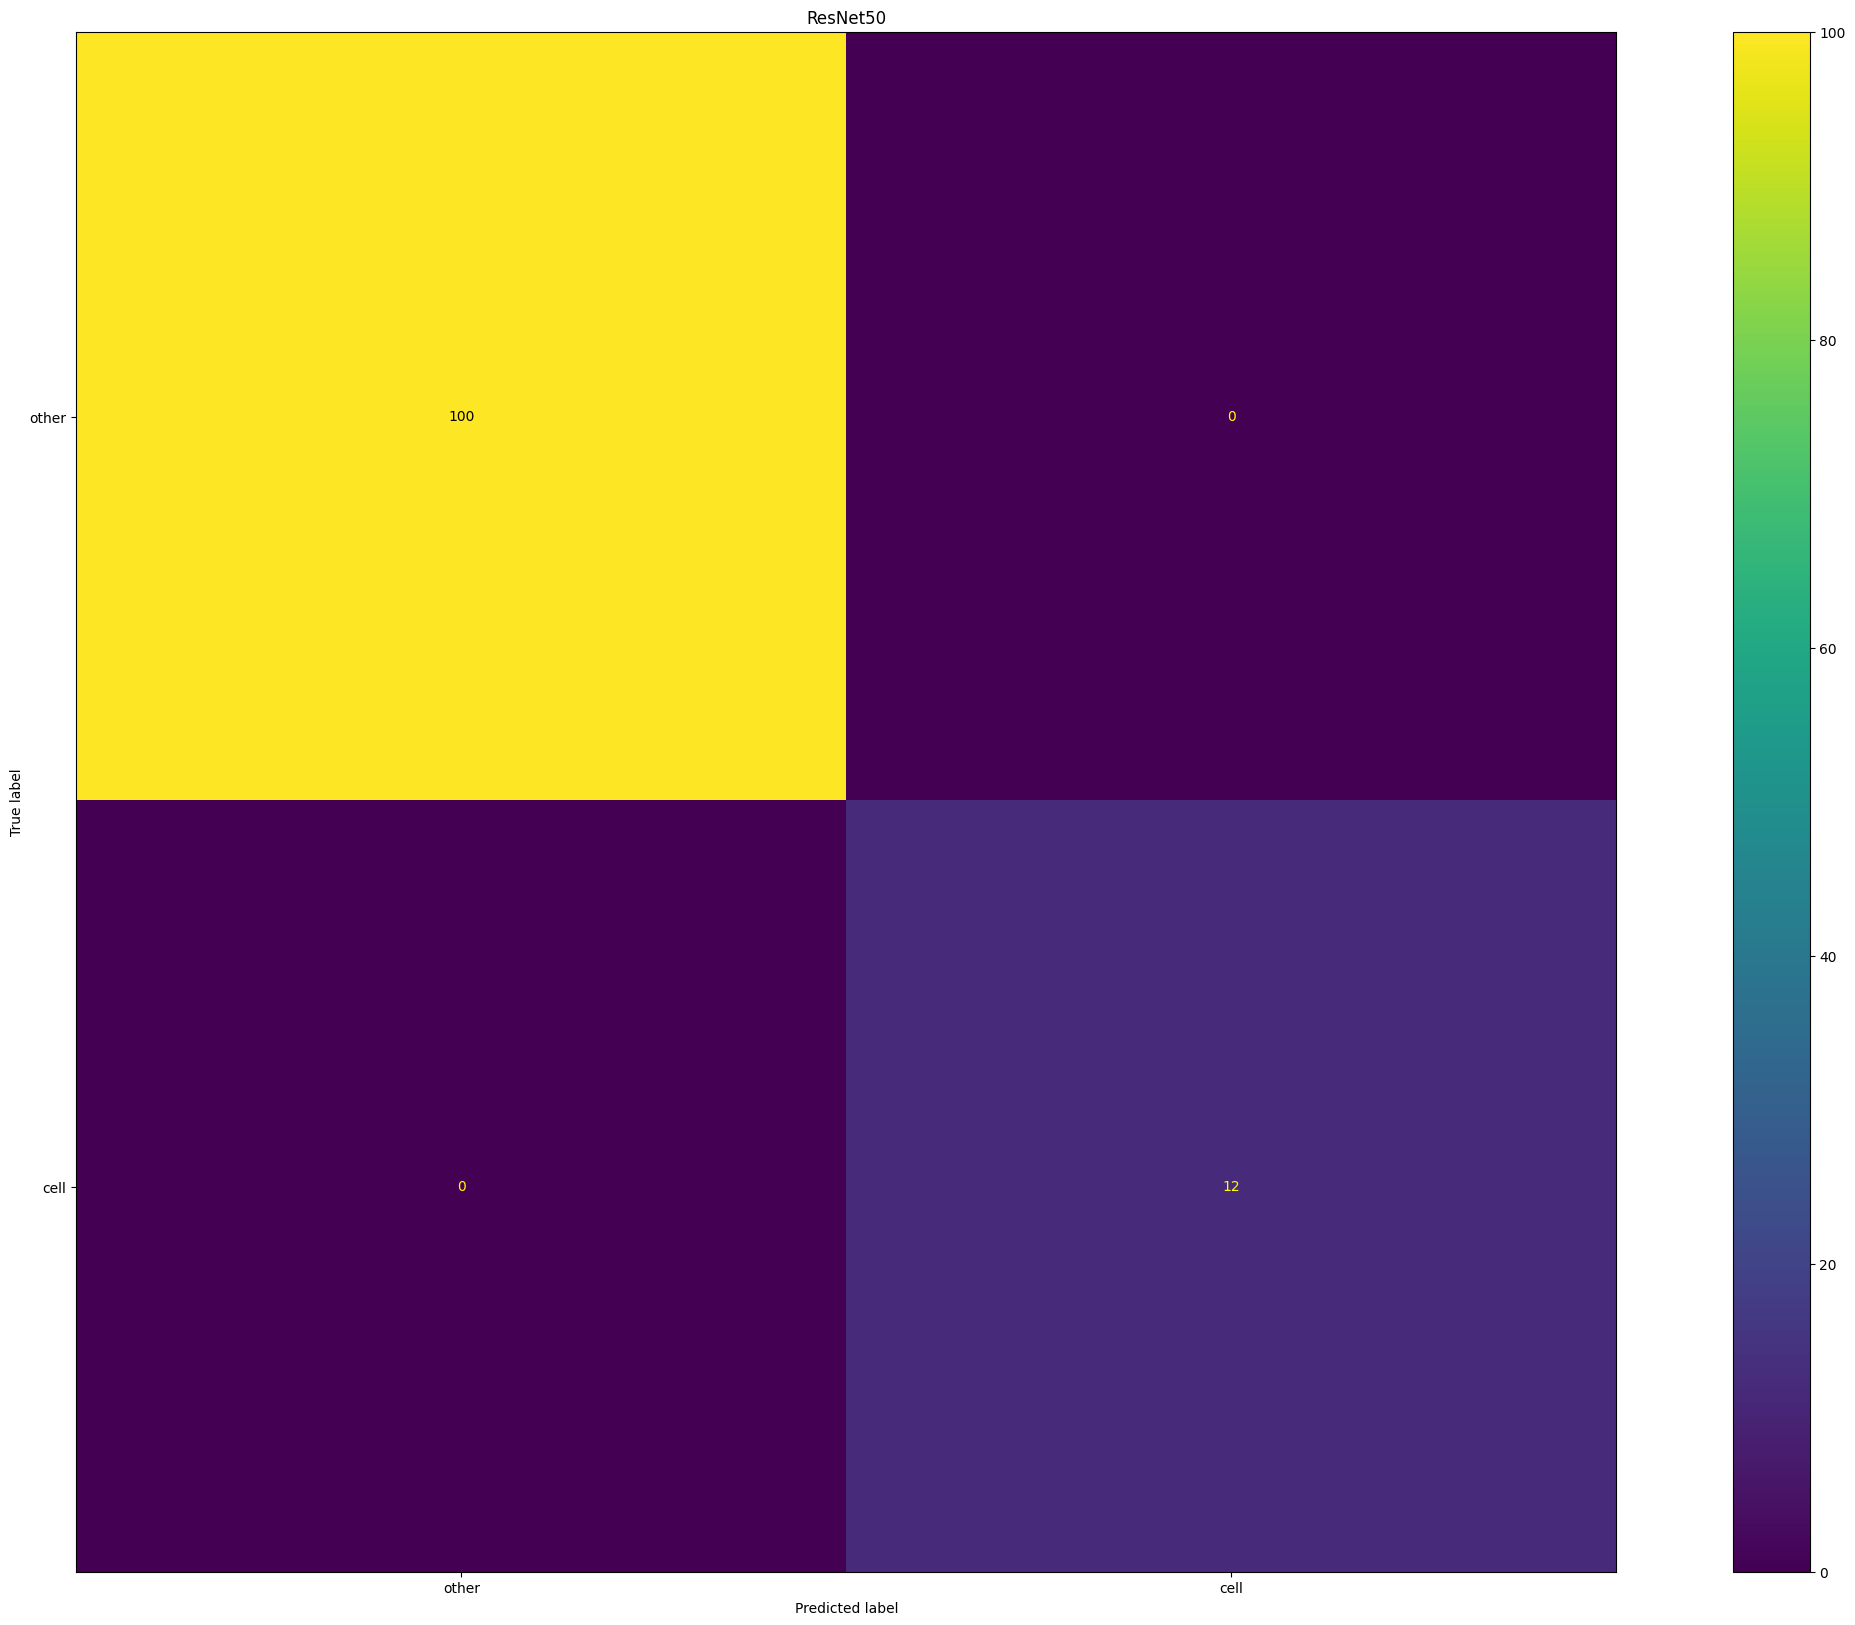

ResNet50 Accuracy: 100.0


In [85]:
############## To Do ##############
res_test_acc = plot_confusion_matrix(resnet_ft,test_loader,classes)
print(f'ResNet50 Accuracy: {res_test_acc}')
###################################

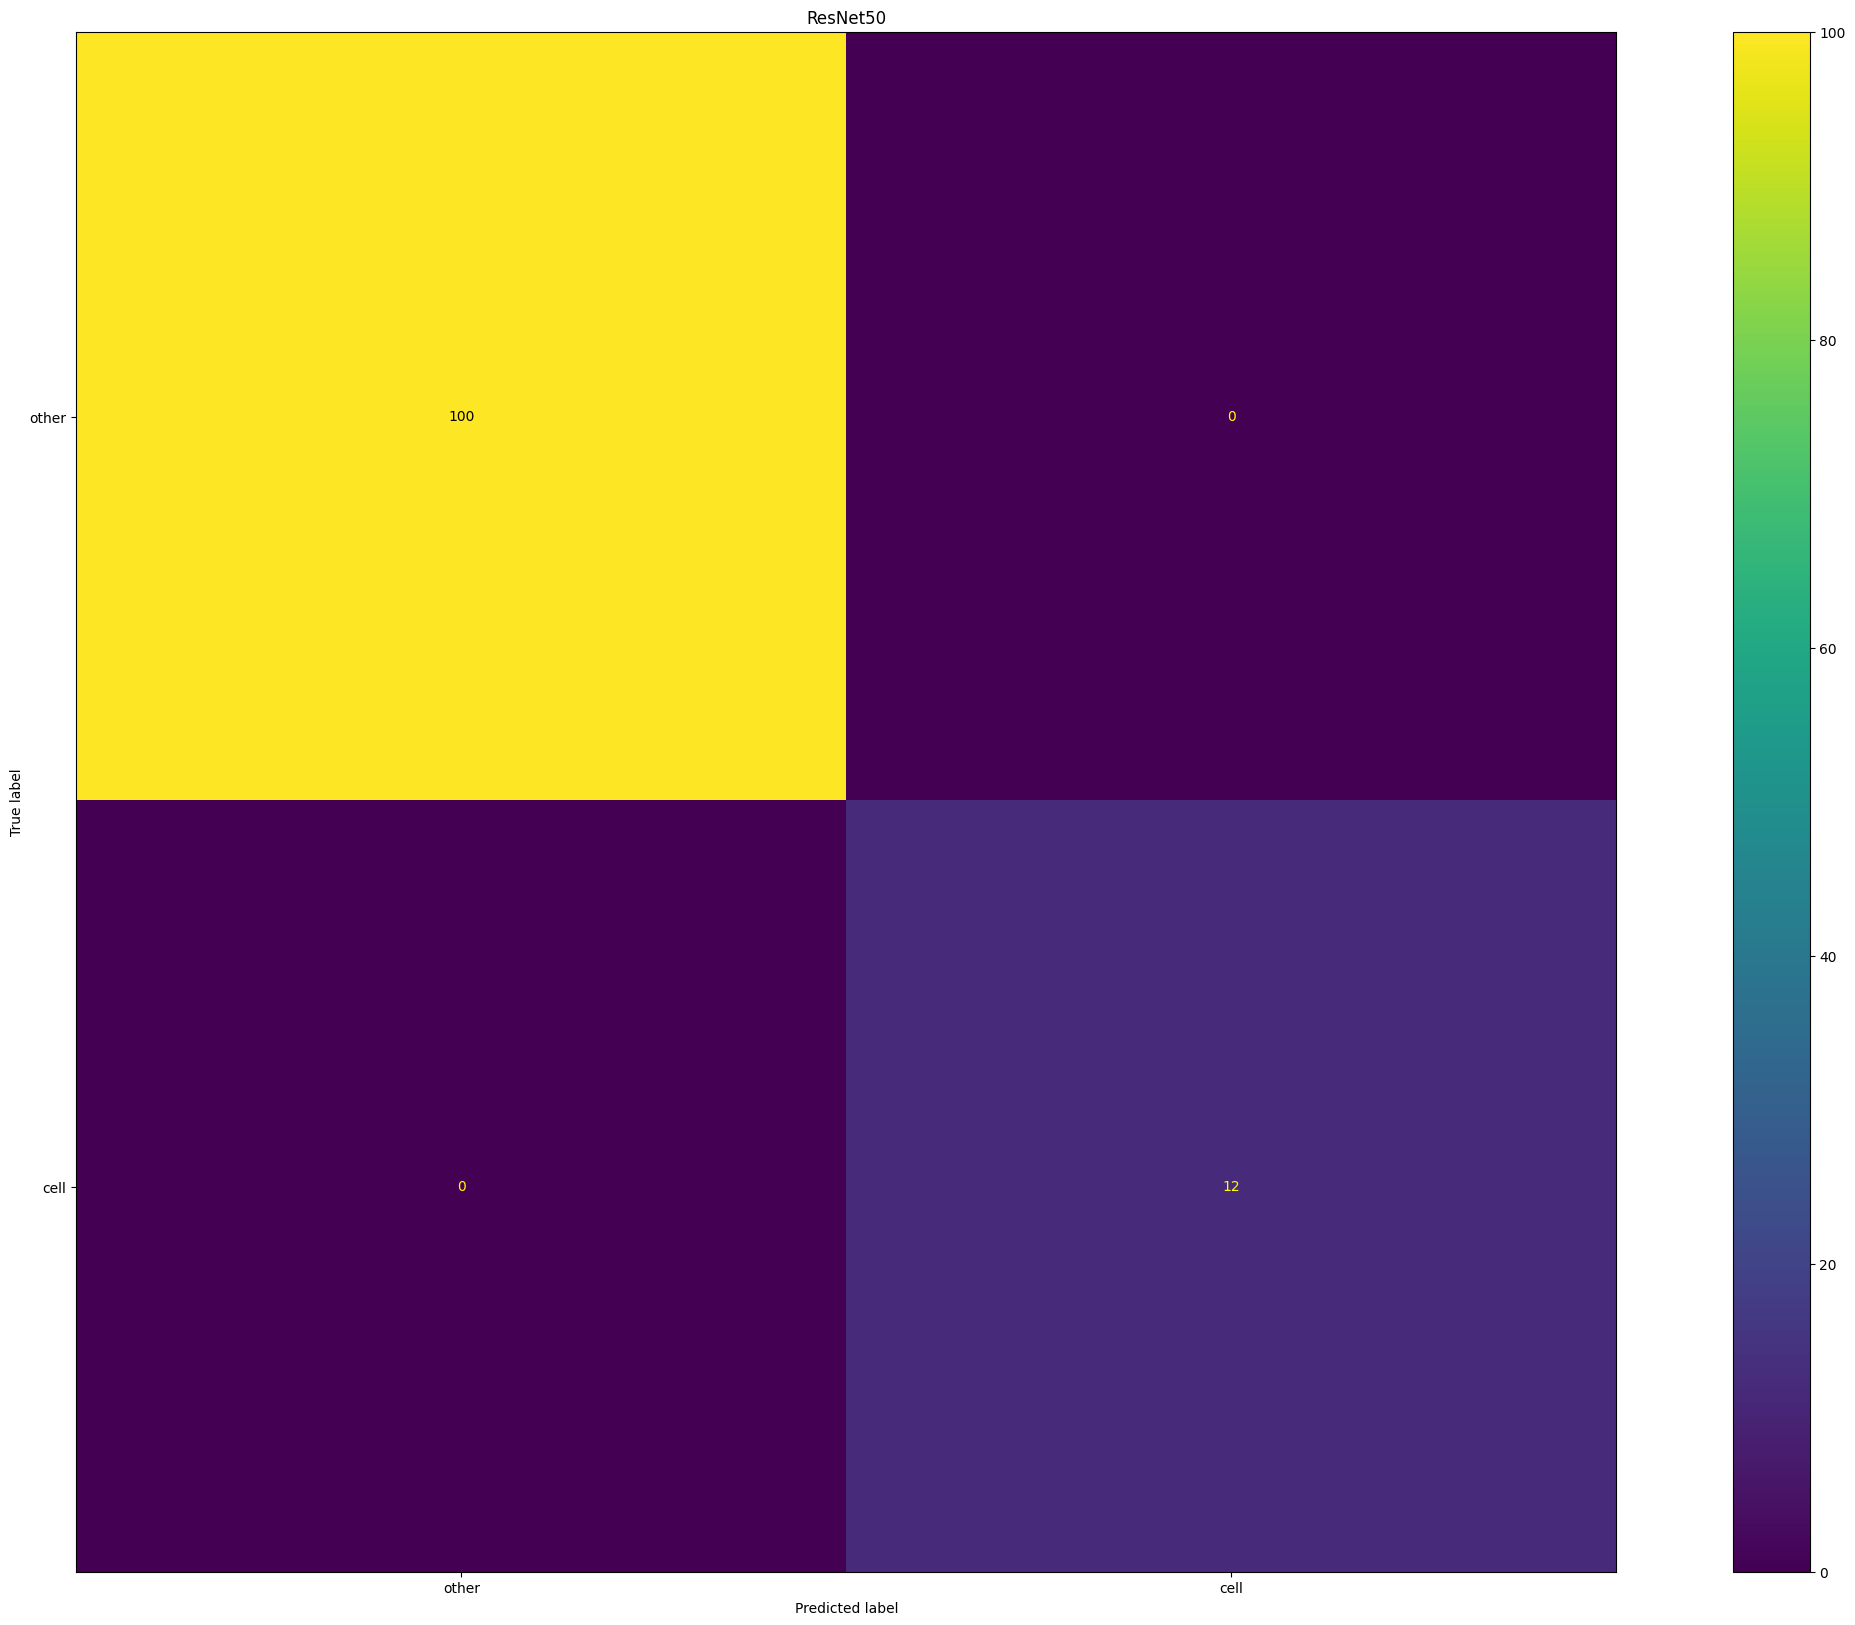

VGG16 Accuracy: 100.0


In [86]:
vgg_test_acc = plot_confusion_matrix(vgg_ft,test_loader,classes)
print(f'VGG16 Accuracy: {vgg_test_acc}')

# 10) Saving Fine-tuned models

In [89]:
save_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/'

# Save the model to a file
torch.save(resnet_ft.state_dict(), save_dir + 'resnet_ft.pt')
torch.save(vgg_ft.state_dict(), save_dir + 'vgg_ft.pt')